In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats, integrate, optimize
import random


In [190]:
# 関数の定義
def model_beta(x, alpha, beta):
    Np = 618
    # alphaとbetaは必ず正の値をとる
    if alpha <= 0 or beta <= 0:
        alpha, beta = 0.01, 0.01
    f = lambda a: (((a**(alpha-1)) * ((1-a)**(beta-1))) / stats.beta.rvs(alpha, beta, size=1) ) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np)) )**(Np - 1)
    ff, _ = integrate.fixed_quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [110]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [111]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [5]:
# left
active_node_list_left, edge_list_left, timestamp_left = return_nm(df_left)

In [6]:
max(active_node_list_left)

618

In [219]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta, xdata=edge_list_left, ydata=active_node_list_left, p0=[1.6, 0.8])

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  1.4624175181807098
beta:  0.8056760963253106


In [192]:
Np = max(active_node_list_left)
alpha = params[0]
beta = params[1]

kappa = []
for i in range(len(edge_list_left)):
    kappa.append( (((alpha + beta)/alpha)**2) * ((2 * edge_list_left[i]) / (Np**2 - Np)) )

In [127]:
N_fit = []
for i in range(len(edge_list_left)):
    N_fit.append(model_beta([edge_list_left[i]], alpha, beta))

In [128]:
M_fit = []
for i in range(len(edge_list_left)):
    M_fit.append(model_beta([edge_list_left[i]], alpha, beta))

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_7893/1461465106.py:10: RuntimeWarning: divide by zero encountered in power
  activity_list.append(((a**(alpha-1)) * ((1-a)**(beta-1))) / deno)


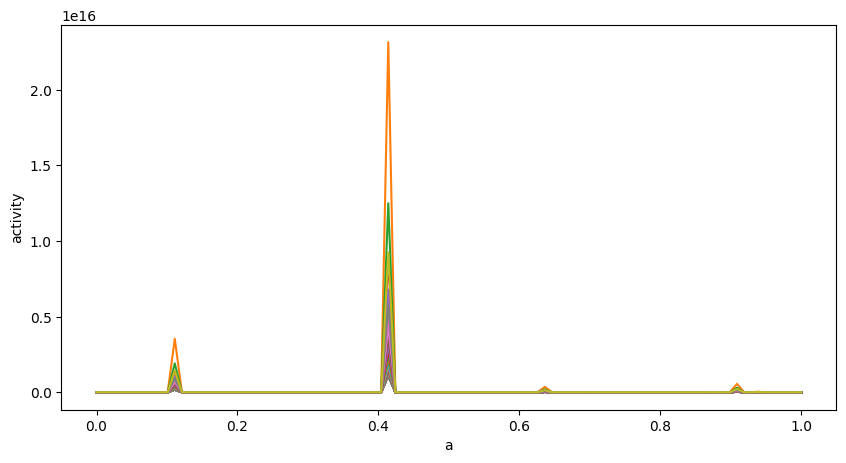

In [195]:
activity_list = []
alpha = params[0]
beta = params[1]

a = np.linspace(0, 1, 100)
for i in range(len(a)):
    deno = random.betavariate(alpha, beta)
    if deno == 0:
        deno = 0.01
    activity_list.append(((a**(alpha-1)) * ((1-a)**(beta-1))) / deno)


# aとactivity_listのグラフ
plt.figure(figsize=(10, 5))
plt.plot(a, activity_list)
plt.xlabel('a')
plt.ylabel('activity')
plt.show()


In [177]:
activity_list

[array([           inf, 9.71098139e+00, 8.41639292e+00, 7.64619892e+00,
        7.08045468e+00, 6.62460013e+00, 6.23793863e+00, 5.89925440e+00,
        5.59608456e+00, 5.32047946e+00, 5.06705172e+00, 4.83197637e+00,
        4.61243541e+00, 4.40628913e+00, 4.21187153e+00, 4.02785759e+00,
        3.85317406e+00, 3.68693776e+00, 3.52841166e+00, 3.37697312e+00,
        3.23209027e+00, 3.09330425e+00, 2.96021561e+00, 2.83247381e+00,
        2.70976887e+00, 2.59182481e+00, 2.47839438e+00, 2.36925475e+00,
        2.26420398e+00, 2.16305818e+00, 2.06564907e+00, 1.97182199e+00,
        1.88143418e+00, 1.79435339e+00, 1.71045663e+00, 1.62962911e+00,
        1.55176339e+00, 1.47675856e+00, 1.40451957e+00, 1.33495667e+00,
        1.26798485e+00, 1.20352343e+00, 1.14149562e+00, 1.08182820e+00,
        1.02445119e+00, 9.69297563e-01, 9.16303021e-01, 8.65405736e-01,
        8.16546176e-01, 7.69666910e-01, 7.24712449e-01, 6.81629097e-01,
        6.40364816e-01, 6.00869105e-01, 5.63092884e-01, 5.269883

In [148]:
a

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

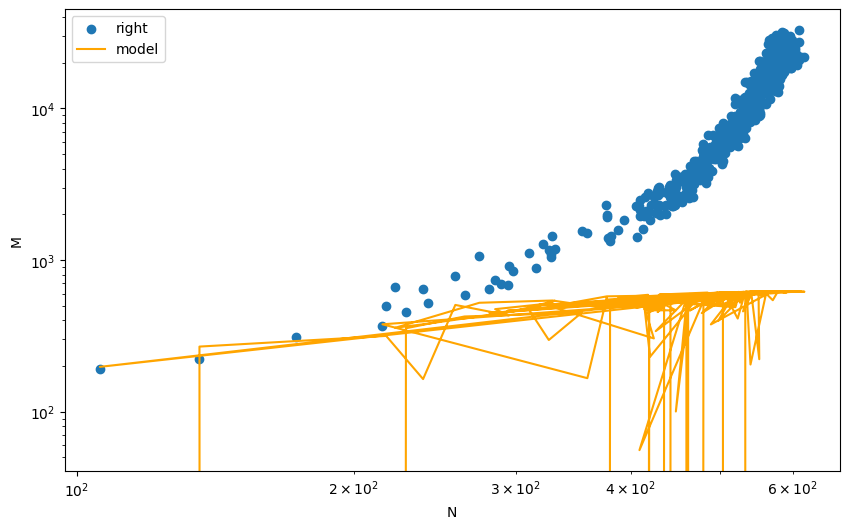

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(active_node_list_left, edge_list_left, label="right")
plt.plot(active_node_list_left, M_fit,label="model", color="orange")
plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


In [13]:
# 正規化する
node_norm = active_node_list_left - min(active_node_list_left) + 2
edge_norm = edge_list_left - min(edge_list_left) + 1

In [14]:
max(node_norm)

514

In [15]:
def model_beta_norm(x, alpha, beta):
    Np = 514
    # alphaとbetaは必ず正の値をとる
    if alpha <= 0 or beta <= 0:
        alpha, beta = 0.01, 0.01
    f = lambda a: (((a**(alpha-1)) * ((1-a)**(beta-1))) / random.betavariate(alpha, beta) ) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np)) )**(Np - 1)
    ff, _ = integrate.fixed_quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [16]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta_norm, xdata=edge_norm, ydata=node_norm)

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  1.0000000489848477
beta:  0.99999997011807


In [17]:
Np = max(node_norm)
alpha = params[0]
beta = params[1]

Nnorm_fit = []
for i in range(len(edge_norm)):
    Nnorm_fit.append(model_beta([edge_norm[i]], alpha, beta))

Mnorm_fit = []
for i in range(len(kappa)):
    Mnorm_fit.append(((kappa[i] * (Np ** 2)) - (kappa[i] * Np)) / 8)

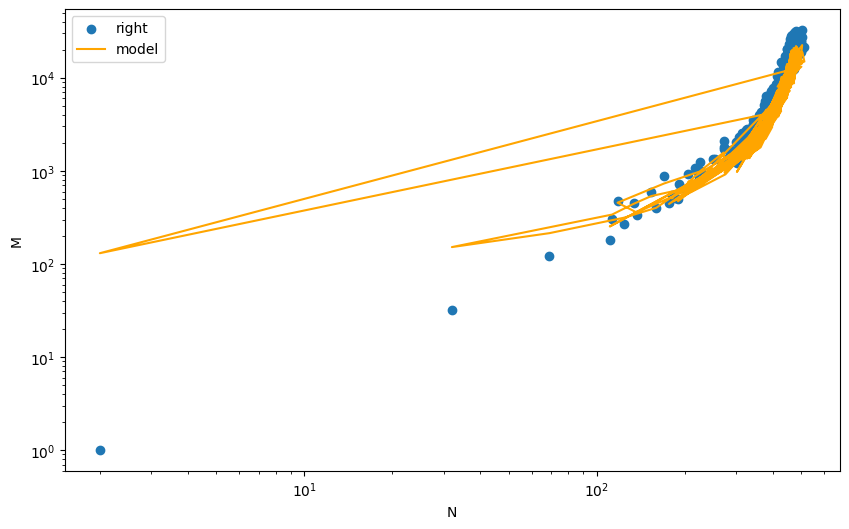

In [18]:
plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
plt.scatter(node_norm, edge_norm, label="right")
plt.plot(node_norm, Mnorm_fit,label="model", color="orange")
plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


## ベータ分布

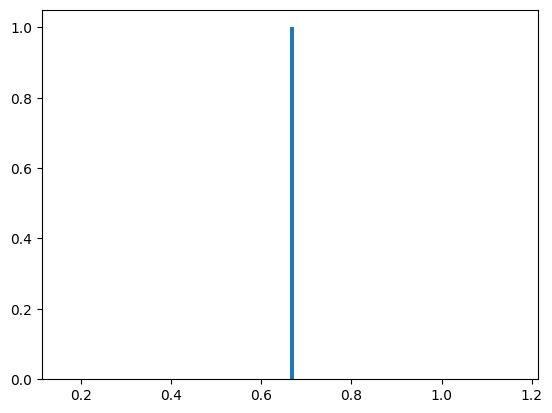

In [189]:
# rvs from beta distribution
alpha = 1.0
beta = 0.5
rvs = stats.beta.rvs(alpha, beta, size=1)
plt.hist(rvs, bins=100)
plt.show()
